In [78]:
from copy import copy, deepcopy
from base64 import b64encode
import numpy as np
import cairocffi as cairo
import imageio
try:
    from cStringIO import StringIO
except ImportError:
    try:
        from StringIO import StringIO
    except ImportError:
        # Python 3 compatibility
        from io import BytesIO as StringIO


def RGB(c):
    if isinstance(c, int):
        return (((c & 0xff0000) >> 16) / 255.0, ((c & 0xff00) >> 8) / 255.0, (c & 0xff) / 255.0)
    else:
        raise Exception('invalid color')



class Surface:
    """
    A Surface is an object on which Elements are drawn, and which can be
    exported as PNG images, numpy arrays, or be displayed into an IPython
    Notebook.

    Note that this class is simply a thin wrapper around Cairo's Surface class.
    """

    def __init__(self, width=640, height=480):
        """"Initialize."""
        self.width = width
        self.height = height
        self._cairo_surface = cairo.ImageSurface(cairo.FORMAT_ARGB32,
                                                 width, height)
        self.context = cairo.Context(self._cairo_surface)

    @staticmethod
    def from_image(image):
        """Initialize the surface from an np array of an image."""
        h, w, d = image.shape
        if d == 4:
            image = image[:, :, [2, 1, 0, 3]]
        if d == 1:
            image = np.array(3 * [image])
        elif d == 3:
            image = image[:, :, [2, 1, 0]]
            image = np.dstack([image, 255 * np.ones((h, w))])
        sf = Surface(w, h)
        arr = np.frombuffer(sf._cairo_surface.get_data(), np.uint8)
        arr += image.flatten()
        sf._cairo_surface.mark_dirty()
        return sf

    def write_to_png(self, filename, y_origin="top"):
        """Write the image to a PNG.

        Parameter y_origin ("top" or "bottom") decides whether point (0,0)
        lies in the top-left or bottom-left corner of the screen.
        """
        imageio.imwrite(filename, self.get_npimage(True), format='png')

    def get_npimage(self, transparent=False, y_origin="top"):
        """ Returns a WxHx[3-4] numpy array representing the RGB picture.

        If `transparent` is True the image is WxHx4 and represents a RGBA
        picture, i.e. array[i,j] is the [r,g,b,a] value of the pixel at
        position [i,j]. If `transparent` is false, a RGB array is returned.

        Parameter y_origin ("top" or "bottom") decides whether point (0,0)
        lies in the top-left or bottom-left corner of the screen.
        """

        im = 0 + np.frombuffer(self._cairo_surface.get_data(), np.uint8)
        im.shape = (self.height, self.width, 4)
        im = im[:, :, [2, 1, 0, 3]]  # put RGB back in order
        if y_origin == "bottom":
            im = im[::-1]
        return im if transparent else im[:, :, :3]

    def get_html_embed_code(self, y_origin="top"):
        """Return an html code containing all the PNG data of the surface. """
        png_data = self._repr_png_()
        data = b64encode(png_data).decode('utf-8')
        return """<img  src="data:image/png;base64,%s">""" % (data)

    def ipython_display(self, y_origin="top"):
        """Display the surface in the IPython notebook.

        Will only work if surface.ipython_display() is written at the end of
        one of the notebook's cells.
        """

        from IPython.display import HTML
        return HTML(self.get_html_embed_code(y_origin=y_origin))

    def _repr_html_(self):
        return self.get_html_embed_code()

    def _repr_png_(self):
        """Return the raw PNG data to be displayed in the IPython notebook."""
        data = StringIO()
        self.write_to_png(data)
        return data.getvalue()
    
    def clear(self, color=(1,1,1)):
        self.context.identity_matrix()
        self.context.rectangle(0,0,self.width,self.height)
        self.context.set_source_rgb(*color)
        self.context.fill()

    def translate(self, x, y):
        self.context.translate(x,y)
        
    def line(self, p0, p1, color=(0,0,0)):
        self.context.move_to(*p0)
        self.context.line_to(*p1)
        self.context.set_line_width(2)
        self.context.set_source_rgb(*color)
        self.context.stroke()

    def draw_axis(self):
        self.context.identity_matrix()
        self.line((0,self.height/2), (self.width, self.height/2))
        self.line((self.width/2,0), (self.width/2, self.height))

    def draw(self, e):
        self.context.save()
        e.draw(self.context)
        self.context.restore()
    

class Element:
    def __init__(self, **kw):
        self.x = kw.get('x', 0)
        self.y = kw.get('y', 0)
        self.fill = kw.get('fill')
        if isinstance(self.fill, int):
            self.fill = RGB(self.fill)
        self.border = kw.get('border', 2)

    def get_size(self):
        return None, None # width, height

    def draw_contour(self, ctx):
        pass
        
    def _set_source(self, ctx, src):
        if len(src) == 4:
            ctx.set_source_rgba(*src)
        else:
            ctx.set_source_rgb(*src)

    def draw(self, ctx):
        ctx.translate(self.x, self.y)
        self.draw_contour(ctx)
        if self.fill:
            self._set_source(ctx, self.fill)
            if self.border > 0:
                ctx.fill_preserve()
            else:
                ctx.fill()
        if self.border > 0:
            ctx.set_line_width(self.border)
            self._set_source(ctx, (0,0,0))
            ctx.stroke()


class Box(Element):
    def __init__(self, w, h, **kw):
        super(Box, self).__init__(**kw)
        self.w = w
        self.h = h

    def get_size(self):
        return self.w, self.h

    def draw_contour(self, ctx):
        ctx.rectangle(self.x-self.w/2, self.y-self.h/2, self.w, self.h)


class Circle(Element):
    def __init__(self, r, **kw):
        super(Circle, self).__init__(**kw)
        self.r = r

    def get_size(self):
        return self.r * 2, self.r * 2

    def draw_contour(self, ctx):
        ctx.move_to(self.x+self.r,self.y)
        ctx.arc(self.x,self.y,self.r,0, 2*np.pi)


class Text(Element):
    def __init__(self, text, fontsize, align='center', **kw):
        fill = kw.pop('fill', 0x000000)
        border = kw.pop('border', 0)
        super(Text, self).__init__(fill=fill, border=border, **kw)
        self.text = str(text)
        self.ff = 'Noto Sans CJK SC'
        self.fontsize = fontsize
        self.w = 0
        self.h = self.fontsize
        self.align = align

    def get_size(self, ctx):
        return self.w, self.h

    def draw_contour(self, ctx):
        print(f'draw text align={self.align}')
        ctx.select_font_face(self.ff)
        ctx.set_font_size(self.fontsize)
        if len(self.text) == 0:
            return
        xbear, ybear, w, h, xadvance, yadvance = ctx.text_extents(self.text)
        print(f'xbear:{xbear} ybear:{ybear} w:{w} h:{h}')
        self.w = w
        self.h = h
        if self.align == 'center':
            x = self.x - w / 2 - xbear
            y = self.y - h / 2 - ybear
        elif self.align == 'left':
            x = self.x - xbear
            y = self.y - h / 2 - ybear
        elif self.align == 'right':
            x = self.x - w - xbear
            y = self.y - h / 2 - ybear
        elif self.align == 'top':
            x = self.x - w / 2 - xbear
            y = self.y - ybear
        elif self.align == 'bottom':
            x = self.x - w / 2 - xbear
            y = self.y - h - ybear
        ctx.move_to(x, y)
        ctx.text_path(self.text)


class Group(Element):
    def __init__(self, children, **kw):
        super(Group, self).__init__(**kw)
        self.children = children
        
    def __len__(self):
        return len(self.children)
    
    def __getitem__(self, idx):
        return self.children.__getitem__(idx)

    def draw(self, ctx):
        ctx.translate(self.x, self.y)
        for e in self.children:
            e.draw(ctx)
        ctx.translate(-self.x, -self.y)


class TextBox(Group):
    def __init__(self, text, fontsize, w, **kw):
        x = kw.pop('x', 0)
        y = kw.pop('y', 0)
        self.t = Text(text, fontsize)
        self.b = Box(w, fontsize, **kw)
        super(TextBox, self).__init__([self.b, self.t], x=x, y=y)

    def get_size(self):
        return self.b.get_size()


class TextBoxVList(Group):
    def __init__(self, texts, fontsize, w, **kw):
        yoffset = -(len(texts)-1)/2*fontsize
        ts = [
            TextBox(e, fontsize, w, y=i*fontsize+yoffset) for i,e in enumerate(texts)
        ]
        super(TextBoxVList, self).__init__(ts, **kw)

    def get_size(self):
        if len(self.children) > 0:
            w, h = self.children[0].get_size()
            return w, len(self.children) * h
        return 0, 0


class TextBoxHList(Group):
    def __init__(self, texts, fontsize, w, **kw):
        xoffset = -(len(texts)-1)/2*w
        ts = [
            TextBox(e, fontsize, w, x=i*w+xoffset) for i,e in enumerate(texts)
        ]
        super(TextBoxHList, self).__init__(ts, **kw)

    def get_size(self):
        if len(self.children) > 0:
            w, h = self.children[0].get_size()
            return w*len(self.children), h
        return 0, 0


def align_reverse(align):
    if align == 'left':
        return 'right'
    elif align == 'right':
        return 'left'
    elif align == 'top':
        return 'bottom'
    elif align == 'bottom':
        return 'top'
    return align


class WithName(Element):
    def __init__(self, name, fontsize, body, align='top', **kw):
        self.align = align
        self.padding = kw.pop('padding', 4)
        self.name = Text(name, fontsize, align=align_reverse(align), fill=kw.pop('fill',0))
        self.body = body
        super(WithName, self).__init__(**kw)

    def draw(self, ctx):
        ctx.translate(self.x, self.y)
        self.body.draw(ctx)
        ctx.save()
        bw, bh = self.body.get_size()
        if self.align == 'left':
            ctx.translate(-bw/2-self.padding, 0)
        elif self.align == 'right':
            ctx.translate(bw/2+self.padding, 0)
        elif self.align == 'top':
            ctx.translate(0, -bh/2-self.padding)
        elif self.align == 'bottom':
            ctx.translate(0, bh/2+self.padding)
        self.name.draw(ctx)
        ctx.restore()
        ctx.translate(-self.x, -self.y)

    def get_size(self):
        return self.body.get_size()


In [79]:
sf = Surface(640, 480)

draw text align=center
xbear:2.0 ybear:-18.0 w:25.0 h:18.0
draw text align=center
xbear:0.0 ybear:-18.0 w:27.0 h:18.0
draw text align=center
xbear:0.0 ybear:-18.0 w:27.0 h:18.0
draw text align=center
xbear:0.0 ybear:-18.0 w:27.0 h:18.0
draw text align=center
xbear:0.0 ybear:-18.0 w:27.0 h:18.0
draw text align=center
xbear:1.0 ybear:-18.0 w:26.0 h:18.0
draw text align=center
xbear:1.0 ybear:-18.0 w:26.0 h:18.0
draw text align=bottom
xbear:0.0 ybear:-22.0 w:56.0 h:22.0



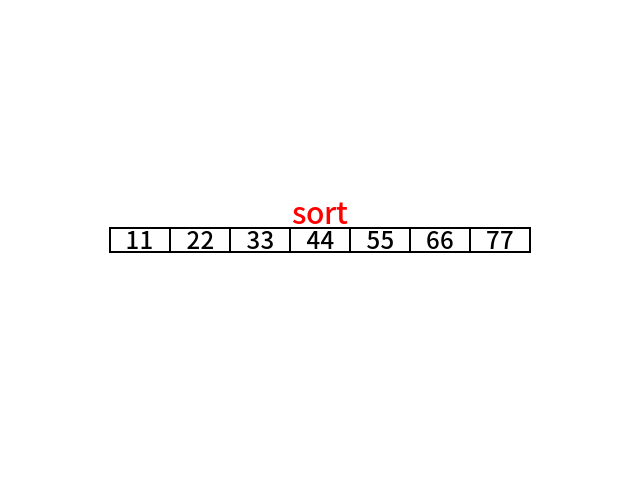

In [81]:
sf.clear()
#sf.draw_axis()
sf.translate(sf.width/2, sf.height/2)
ts = TextBoxHList([11,22,33,44,55,66,77], 24, 60)
wn = WithName('sort', 30, ts, 'top', fill=0xff0000)
sf.draw(wn)
sf.ipython_display()

In [82]:
import random

def gen_merge_sort(sz):
    data = list(range(sz))
    random.shuffle(data)
    history = []
    def dump():
        history.append({'data': data.copy()})
    def merge(arr, start, mid, end):
        start2 = mid + 1;
        if arr[mid] <= arr[start2]:
            return
        while start <= mid and start2 <= end:
            # If element 1 is in right place
            if arr[start] <= arr[start2]:
                start += 1
            else:
                value = arr[start2]
                index = start2
                # Shift all the elements between element 1
                # element 2, right by 1.
                while index != start:
                    arr[index] = arr[index - 1]
                    index -= 1
                arr[start] = value
                start += 1;
                mid += 1;
                start2 += 1;

    def mergeSort(arr, l, r):
        if l < r:
            m = l + (r - l) // 2
            # Sort first and second halves
            mergeSort(arr, l, m)
            mergeSort(arr, m + 1, r)
            merge(arr, l, m, r)
            dump()
    mergeSort(data, 0, len(data)-1)
    return history


In [83]:
hi = gen_merge_sort(10)